Found 215 images belonging to 2 classes.
Found 52 images belonging to 2 classes.
Found 252 images belonging to 2 classes.
Train for 7.0 steps, validate for 2.0 steps
Epoch 1/10
7/7 [==============================] - 414s 59s/step - loss: 0.6731 - accuracy: 0.5860 - val_loss: 0.7520 - val_accuracy: 0.5962
Epoch 2/10
7/7 [==============================] - 393s 56s/step - loss: 0.5029 - accuracy: 0.7535 - val_loss: 0.7604 - val_accuracy: 0.5962
Epoch 3/10
7/7 [==============================] - 394s 56s/step - loss: 0.4411 - accuracy: 0.7860 - val_loss: 0.8106 - val_accuracy: 0.5962
Epoch 4/10
7/7 [==============================] - 373s 53s/step - loss: 0.3348 - accuracy: 0.8791 - val_loss: 0.8215 - val_accuracy: 0.5962
Epoch 5/10
7/7 [==============================] - 361s 52s/step - loss: 0.3157 - accuracy: 0.8930 - val_loss: 0.8362 - val_accuracy: 0.5962
Epoch 6/10
7/7 [==============================] - 372s 53s/step - loss: 0.3103 - accuracy: 0.9023 - val_loss: 0.8734 - val_accuracy: 0

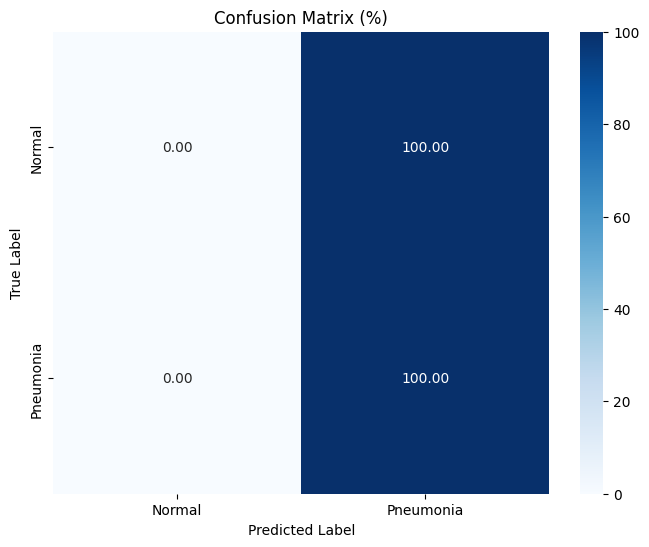

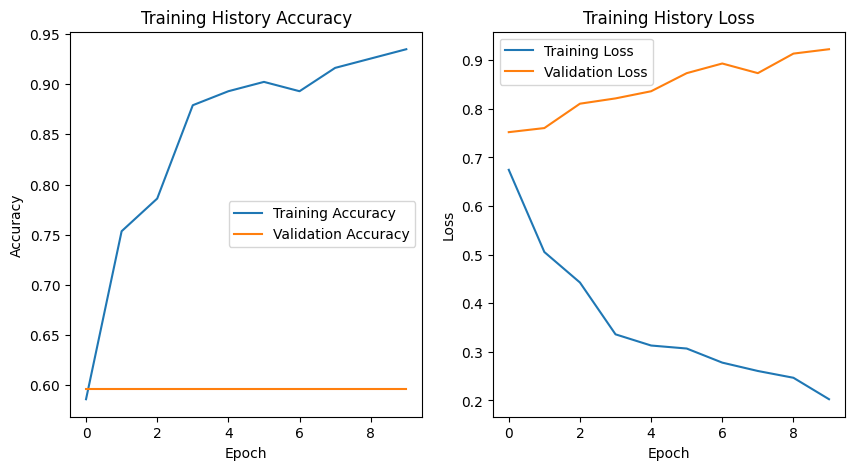

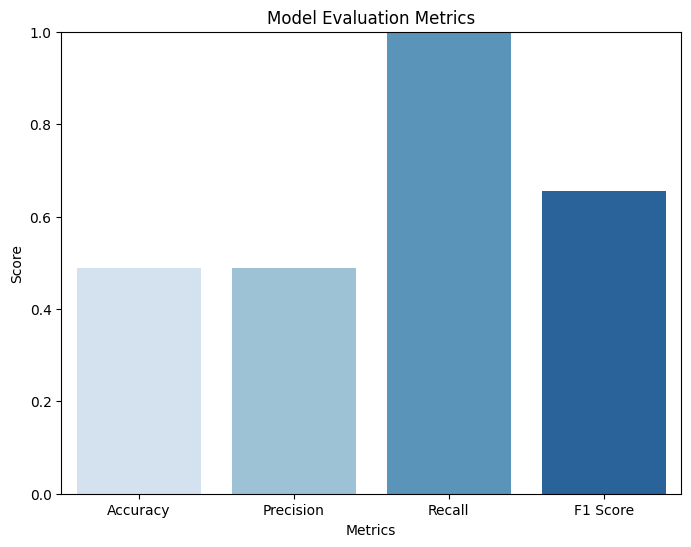

In [ ]:
import tensorflow as tf
import numpy as np
import os
import cv2
import PIL
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns  # For confusion matrix visualization
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

# Suppress TensorFlow warnings
tf.get_logger().setLevel('ERROR')

# 1. Data Loading and Preprocessing
IMG_SIZE = 224
BATCH_SIZE = 32

DATA_DIR = r'Add your dataset path'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Split 20% for validation
)

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(DATA_DIR, 'train'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

validation_generator = val_datagen.flow_from_directory(
    os.path.join(DATA_DIR, 'train'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(DATA_DIR, 'test'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# 2. Model Building (Transfer Learning with ResNet50)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Binary classification (Normal vs Pneumonia)
])

# 3. Model Compilation and Training
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

epochs = 10
history = model.fit(
    train_generator,
    steps_per_epoch=np.ceil(train_generator.samples / BATCH_SIZE),
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=np.ceil(validation_generator.samples / BATCH_SIZE)
)

# 4. Model Evaluation
if test_generator.samples > 0:
    loss, accuracy = model.evaluate(test_generator, steps=len(test_generator))
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")

    Y_pred = model.predict(test_generator, steps=len(test_generator))
    y_pred = (Y_pred > 0.5).astype(int).flatten()  # Convert probabilities to binary
    y_true = test_generator.classes

    # Check class distribution
    unique, counts = np.unique(y_true, return_counts=True)
    print("Class distribution in test set:", dict(zip(unique, counts)))

    print('\nClassification Report:')
    print(classification_report(y_true, y_pred, target_names=['Normal', 'Pneumonia'], zero_division=1))

    cm = confusion_matrix(y_true, y_pred)
    print("\nConfusion Matrix:")
    print(cm)

    precision = precision_score(y_true, y_pred, zero_division=1)
    recall = recall_score(y_true, y_pred, zero_division=1)
    f1 = f1_score(y_true, y_pred, zero_division=1)

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    if accuracy < 0.92:
        print("\n⚠ WARNING: Model accuracy is below 92%! Consider retraining or tuning hyperparameters.")
    else:
        print("\n✅ Model meets the required accuracy threshold (>= 92%).")

    # Convert confusion matrix to percentage
    cm_percentage = np.nan_to_num(cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap='Blues',
                xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix (%)')
    plt.show()

    # Plot training history
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training History Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training History Loss')
    plt.show()

    # Bar plot for evaluation metrics
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    values = [accuracy, precision, recall, f1]

    plt.figure(figsize=(8, 6))
    sns.barplot(x=metrics, y=values, palette='Blues')
    plt.ylim(0, 1)
    plt.xlabel('Metrics')
    plt.ylabel('Score')
    plt.title('Model Evaluation Metrics')
    plt.show()

# Save the model
model.save("pneumonia_model.h5")
